# U-Net 2D (baseline control)  

(baseline model)


```python
""" A baseline control U-Net2D training pipeline (Google colab tutorial)

    MEDCNN: Multiresolution Encoder-Decoder Convolutional Neural Network
    Copyright (C) 2025 Kishore Kumar Tarafdar
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""
```

In [1]:
pwd

'/content'

In [2]:
!python --version

Python 3.11.11


GPU availability?

In [3]:
import tensorflow as tf
print(f"TensorFlow version {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
len(gpus)

TensorFlow version 2.18.0
Num GPUs Available:  1


1

Select one GPU

        Restrict code to use a particular GPU...

In [4]:
!pip install MEDCNN

In [5]:
# from MEDCNN.utils.tf_select_a_gpu import select_a_gpu

In [6]:
# # select_gpu = gpus[gpu_id]
# memory_limit = 16 #GB
# select_a_gpu(gpus, gpu_id = 1, memory_limit=memory_limit)
# # del gpu_id, select_a_gpu, select_gpu

In [7]:
# !nvidia-smi

In [8]:
49140//1024

47

In [9]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [10]:
# pip install tqdm
# pip install scikit-learn
# pip install scikit-image
# pip install nibabel
# pip install matplotlib

In [11]:
# import tensorflow as tf
import keras
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from IPython import display
import time

        load utils..

In [13]:
from MEDCNN.utils.utils import elapsedtime, timestamp
from MEDCNN.utils.BoundaryAwareDiceLoss import BoundaryAwareDiceLoss
from MEDCNN.utils.Load2Ddata import load_ibsr_XY
from MEDCNN.utils.TTViterators import get_train_test_val_iterators
from MEDCNN.utils.dice import dice_coef
from MEDCNN.utils.compile1 import compile_model
from MEDCNN.utils.Train1 import train


In [ ]:
# ls /home/kishoretarafdar/

In [14]:
start_time=time.time()

# Time elapsed
end_time = time.time()
print(elapsedtime(start_time, end_time))
del start_time, end_time

Elapsed time: mm:ss:mss 	 00:00:000
00:00:000


In [15]:
timestamp(time.time())

2025-04-04 19:34:04.232758


'20250404'

In [ ]:
break

IoU as loss (approx.)  $IoU'=\frac{|T*P|}{|T+P-(T*P)|}=\frac{I}{U}$

$Dice=\frac{2*Intersection}{Union+Intersection}$

Boundary aware dice loss



---

# Data loader: Load complete IBSR

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
ls drive/MyDrive/IBSR_cooked_XY_SkullStripping/

IBSR_X.npy  IBSR_Y.npy


In [18]:
datapath = '/content/drive/MyDrive/IBSR_cooked_XY_SkullStripping/'
X, Y, dataset = load_ibsr_XY(datapath)
X.shape, Y.shape, dataset

((7056, 256, 256, 1), (7056, 256, 256, 1), 'IBSR')

Taking a small set from the entire data due to limited RAM in Google colab

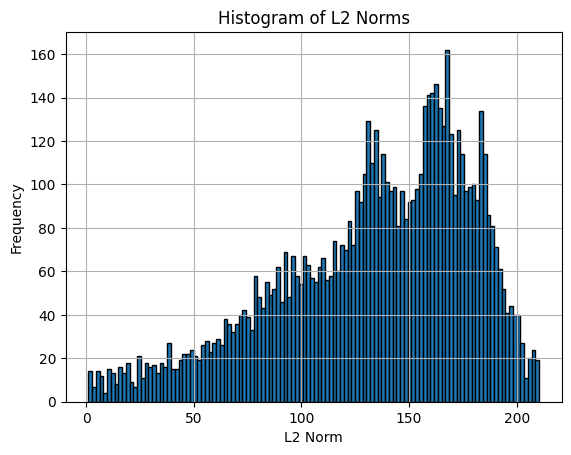

In [19]:
# Compute L2 norms for all slices
l2_norms = [np.linalg.norm(Y[k,...]) for k in range(Y.shape[0])]

# Plot histogram
plt.hist(l2_norms, bins=120, edgecolor='black')
plt.title('Histogram of L2 Norms of RoIs')
plt.xlabel('L2 Norm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
margin = 100 ##!!
margin2 = 175 ##!!
keepindices = []
for k in range(Y.shape[0]):
    l2_norm = np.linalg.norm(Y[k,...])
    if l2_norm < margin or l2_norm > margin2:
        continue
    keepindices.append(k)
print(len(keepindices))

4151


In [21]:
X_l2filt = X[keepindices]
Y_l2filt = Y[keepindices]
X_l2filt.shape, Y_l2filt.shape

((4151, 256, 256, 1), (4151, 256, 256, 1))

In [22]:
pwd

'/content'

In [23]:
# ls /data1/kishoretarafdar/FILESHARE/IBSR_cookedXY_allplanes/IBSR_XY_skullstripping

In [24]:
# datapath = '/data1/kishoretarafdar/FILESHARE/IBSR_cookedXY_allplanes/IBSR_XY_skullstripping'
# X, Y, dataset = load_ibsr_XY(datapath)
# X.shape, Y.shape, dataset

In [25]:
# X, Y = X[0:88,...], Y[0:88,...]

In [26]:
break

SyntaxError: 'break' outside loop (<ipython-input-26-6aaf1f276005>, line 1)

## Train Test split

In [27]:
# from TTViterators import get_train_test_val_iterators
X, Y = X_l2filt, Y_l2filt
train_iterator, test_iterator, val_iterator = get_train_test_val_iterators(X,Y)
del X, Y, X_l2filt, Y_l2filt

True (3320, 256, 256, 1)
(3320, 256, 256, 1) (3320, 256, 256, 1) float32 float32 <class 'numpy.ndarray'> <class 'numpy.ndarray'> (831, 256, 256, 1) (831, 256, 256, 1) float32 float32 <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Train  True (2988, 256, 256, 1) True float32
Val    True (332, 256, 256, 1) True float32
Test.  True (831, 256, 256, 1) True float32


In [28]:
# tmp
# from TTViterators import get_train_test_val_iterators
#train_iterator, test_iterator, val_iterator = get_train_test_val_iterators(X[0:6,:,:,:],Y[0:6,:,:,:])

In [29]:
# # Normalization (assumned inside model)
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(...)
# datagen.fit(X_train)

In [30]:
# batch_size = 20
# train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_size)
# val_iterator = datagen.flow(X_val, Y_val, batch_size=batch_size)
# test_iterator = datagen.flow(X_test, Y_test, batch_size=batch_size)

In [31]:
break

SyntaxError: 'break' outside loop (<ipython-input-31-6aaf1f276005>, line 1)

In [ ]:
# next(train_iterator).shape

# Load and compile model

In [32]:
from MEDCNN.models.ControlUnet2D import Unet2D, uconfigs

In [37]:
pwd

'/content/traininglogs'

In [34]:
# mkdir traininglogs

In [35]:
cd traininglogs

/content/traininglogs


In [36]:
ls -lart

total 8
drwxr-xr-x 1 root root 4096 Apr  4 19:35 ../
drwxr-xr-x 2 root root 4096 Apr  4 19:35 ./


In [38]:
# CONFIGKEY= '4567'
# CONFIGKEY= '3456'
# model, segconfig = Unet2d(config=configs[CONFIGKEY], compile=False), 'nonResidual'
# model, segconfig = Gφψ(config=configs[CONFIGKEY], compile=False), 'nonResidual'
CONFIGKEY = '45678',
model, segconfig = Unet2D(config=uconfigs['45678'], compile=False), 'nonResidual'
model, lossname = compile_model(model, dataset, dice_coef)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,940,834 (7.40 MB)

 Trainable params: 1,940,834 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
break

# Train one model

In [39]:
pwd

'/content/traininglogs'

In [40]:
ls -lart

total 1124
drwxr-xr-x 1 root root    4096 Apr  4 19:35 ../
-rw-r--r-- 1 root root 1142667 Apr  4 19:36 model.png
drwxr-xr-x 2 root root    4096 Apr  4 19:36 ./


In [41]:
dataset, lossname, segconfig, CONFIGKEY

('IBSR', 'bce', 'nonResidual', ('45678',))

In [42]:
break

SyntaxError: 'break' outside loop (<ipython-input-42-6aaf1f276005>, line 1)

2025-04-04 19:36:49.225899
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - IoU: 0.5769 - accuracy: 0.7227 - dice_coef: 0.7286 - loss: 0.4259
Epoch 1: val_loss improved from inf to 0.13361, saving model to 20250404G_IBSR_nonResidual_bce_config('45678',).keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 364ms/step - IoU: 0.5779 - accuracy: 0.7235 - dice_coef: 0.7293 - loss: 0.4250 - val_IoU: 0.9057 - val_accuracy: 0.9505 - val_dice_coef: 0.9354 - val_loss: 0.1336
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - IoU: 0.9246 - accuracy: 0.9608 - dice_coef: 0.9555 - loss: 0.0952
Epoch 2: val_loss improved from 0.13361 to 0.08843, saving model to 20250404G_IBSR_nonResidual_bce_config('45678',).keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - IoU: 0.9247 - accuracy: 0.9609 - dice_coef: 0.9555 - loss: 0.0952 - val_IoU: 0.9286 - val_accuracy: 0.9630 - val_dice_coef: 0.9571 - val_loss: 0.0884
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - IoU: 0.9453 - accuracy: 0.9719 - dice_coef: 0.9679 - loss: 0.0665
Epoch 3: val_

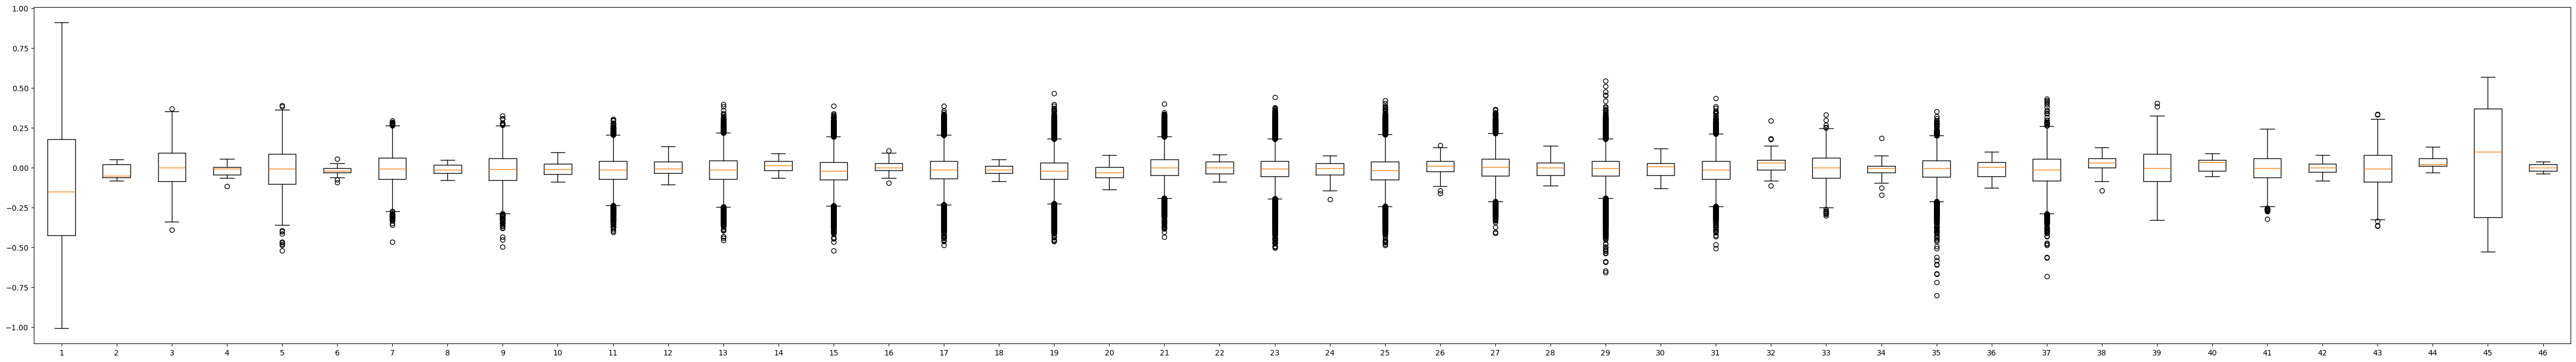

Elapsed time: mm:ss:mss 	 38:30:945


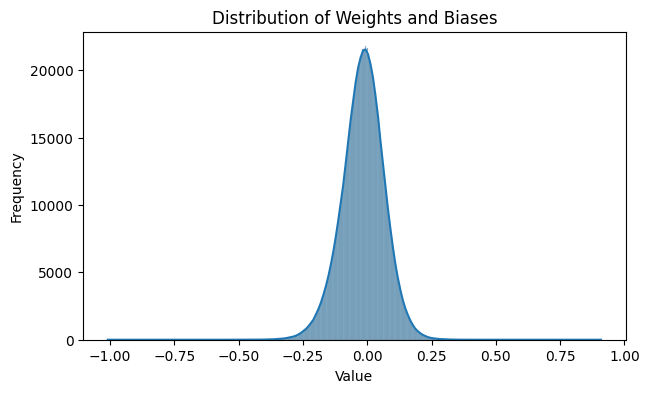

In [44]:
# from MEDCNN.utils.Train1 import train
epochs = 40
train(model, train_iterator, test_iterator, val_iterator, dataset=dataset, segconfig=segconfig , lossname=lossname, CONFIGKEY=CONFIGKEY, epochs=epochs)


# Assuming `model` is your trained U-Net model
model_weights = model.get_weights()
all_weights = np.concatenate([w.flatten() for w in model_weights])
import seaborn as sns

# Plotting the histogram
plt.figure(figsize=(7, 4))
sns.histplot(all_weights, bins=900, kde=True)
plt.title('Distribution of Weights and Biases')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [45]:
model_weights = model.get_weights()
[_.shape for _ in model_weights]
[_.dtype for _ in model_weights]

[dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32')]

In [46]:
a = [_ for _ in model_weights if len(_.shape)>1 and _.shape[0]>1]
[_.shape for _ in a]

[(3, 3, 1, 16),
 (3, 3, 16, 16),
 (3, 3, 16, 32),
 (3, 3, 32, 32),
 (3, 3, 32, 64),
 (3, 3, 64, 64),
 (3, 3, 64, 128),
 (3, 3, 128, 128),
 (3, 3, 128, 256),
 (3, 3, 256, 256),
 (2, 2, 128, 256),
 (3, 3, 256, 128),
 (3, 3, 128, 128),
 (2, 2, 64, 128),
 (3, 3, 128, 64),
 (3, 3, 64, 64),
 (2, 2, 32, 64),
 (3, 3, 64, 32),
 (3, 3, 32, 32),
 (2, 2, 16, 32),
 (3, 3, 32, 16),
 (3, 3, 16, 16)]

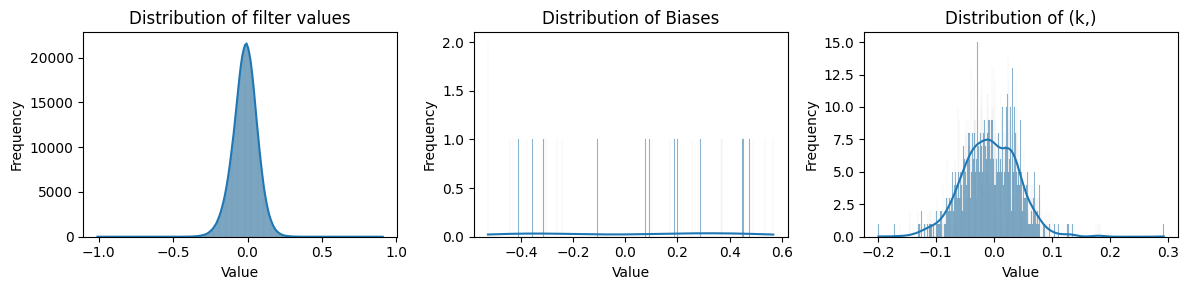

In [47]:
# Assuming `model` is trained U-Net model
model_weights = model.get_weights()
# a = [_ for _ in model_weights if len(_.shape)>1]
a = [_ for _ in model_weights if len(_.shape)>1 and _.shape[0]>1]
b = [_ for _ in model_weights if len(_.shape)>1 and _.shape[0]==1]
c = [_ for _ in model_weights if len(_.shape)==1]
c
# all_weights = np.concatenate([w.flatten() for w in model_weights])
# all_weights.shape


# Assuming `model` is your trained U-Net model
# model_weights = model.get_weights()
# all_weights = np.concatenate([w.flatten() for w in model_weights])
all_filter_vals = np.concatenate([w.flatten() for w in a])
all_bias1 = np.concatenate([w.flatten() for w in b])
all_bias2 = np.concatenate([w.flatten() for w in c])
import seaborn as sns

# Plotting the histogram
plt.figure(figsize=(12, 3))
plt.subplot(131)
sns.histplot(all_filter_vals, bins=900, kde=True)
plt.title('Distribution of filter values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(132)
sns.histplot(all_bias1, bins=900, kde=True)
plt.title('Distribution of Biases')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(133)
sns.histplot(all_bias2, bins=900, kde=True)
plt.title('Distribution of (k,)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [48]:
model_weights[2].shape

(3, 3, 16, 16)

In [49]:
model.weights[0][:,:,0,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.16366692, -0.38134342, -0.19092755],
       [ 0.6760083 , -0.37780294, -0.42419833],
       [-0.8939808 ,  0.8171369 , -1.0089415 ]], dtype=float32)>

In [50]:
a[6].shape

(3, 3, 64, 128)

In [51]:
import math

def next_perfect_square(n):
    root = math.ceil(math.sqrt(n))
    return root ** 2

# Given number
# n = 65

# Find the next perfect square
# next_square = next_perfect_square(n)
# next_square

In [52]:
[_.shape for _ in a]

[(3, 3, 1, 16),
 (3, 3, 16, 16),
 (3, 3, 16, 32),
 (3, 3, 32, 32),
 (3, 3, 32, 64),
 (3, 3, 64, 64),
 (3, 3, 64, 128),
 (3, 3, 128, 128),
 (3, 3, 128, 256),
 (3, 3, 256, 256),
 (2, 2, 128, 256),
 (3, 3, 256, 128),
 (3, 3, 128, 128),
 (2, 2, 64, 128),
 (3, 3, 128, 64),
 (3, 3, 64, 64),
 (2, 2, 32, 64),
 (3, 3, 64, 32),
 (3, 3, 32, 32),
 (2, 2, 16, 32),
 (3, 3, 32, 16),
 (3, 3, 16, 16)]

In [53]:
a[9].shape

(3, 3, 256, 256)

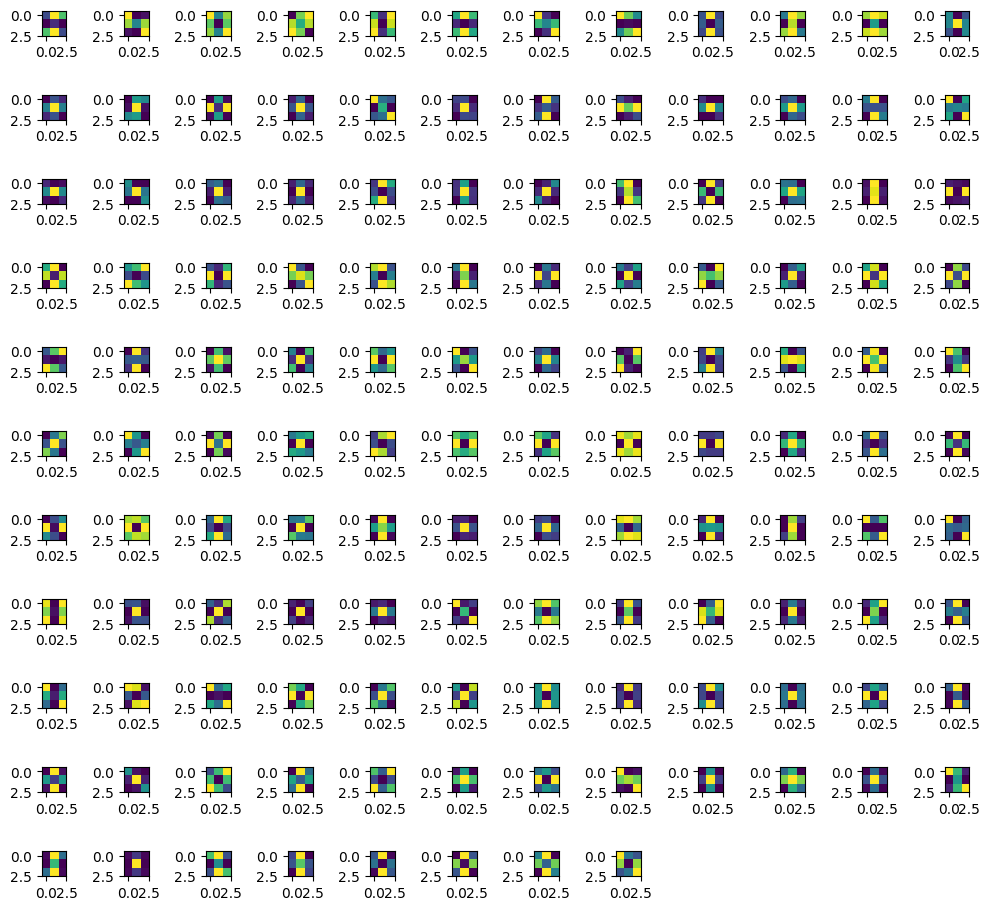

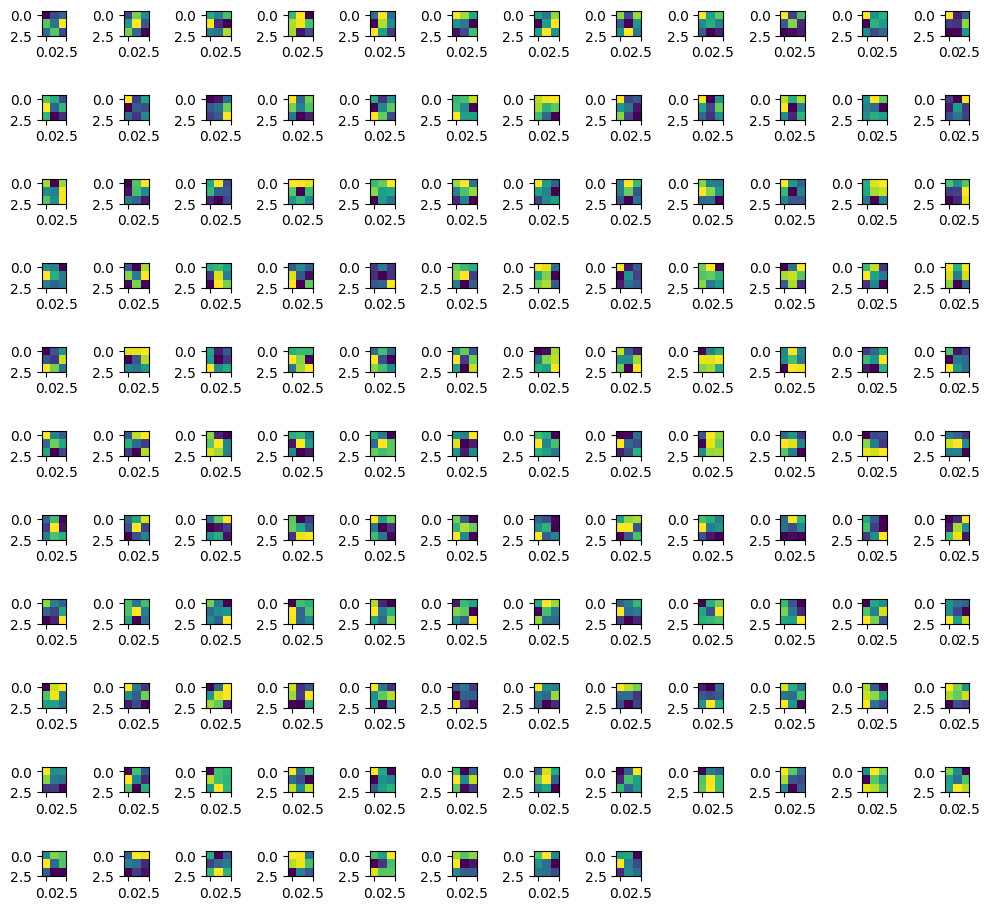

In [54]:
#MEDCNN plot
idx = 6
ch = 9
_ = a[idx]
grid = int(np.sqrt(next_perfect_square(_.shape[-1])))
plt.figure(figsize=(10,10))
for i in range(_.shape[-1]):
    plt.subplot(grid,grid,i+1)
    # plt.imshow(tf.abs(model.weights[0][:,:,0,i]))
    # plt.imshow(_[:,:,ch,i])#.astype(np.float32))
    plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(_[:,:,ch,i]))))#.astype(np.float32))
    # plt.imshow(np.angle(np.fft.fft2(_[:,:,1,i])))#.astype(np.float32))
plt.tight_layout()


grid = int(np.sqrt(next_perfect_square(_.shape[-1])))
plt.figure(figsize=(10,10))
for i in range(_.shape[-1]):
    plt.subplot(grid,grid,i+1)
    # plt.imshow(tf.abs(model.weights[0][:,:,0,i]))
    plt.imshow(_[:,:,ch,i])#.astype(np.float32))
    # plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(_[:,:,ch,i]))))#.astype(np.float32))
    # plt.imshow(np.angle(np.fft.fft2(_[:,:,1,i])))#.astype(np.float32))
plt.tight_layout()

# Predict and view test MR slices

In [55]:
X_batch, Y_batch = test_iterator.__getitem__(0)
X_batch.shape, Y_batch.shape

((20, 256, 256, 1), (20, 256, 256, 2))

In [56]:
yhat = model.predict(X_batch)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(20, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


(20, 256, 256, 1) (20, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
(20, 256, 256, 2) <<
(20, 256, 256) <<


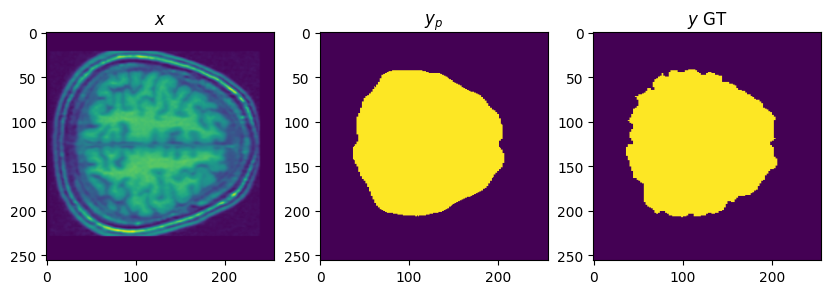

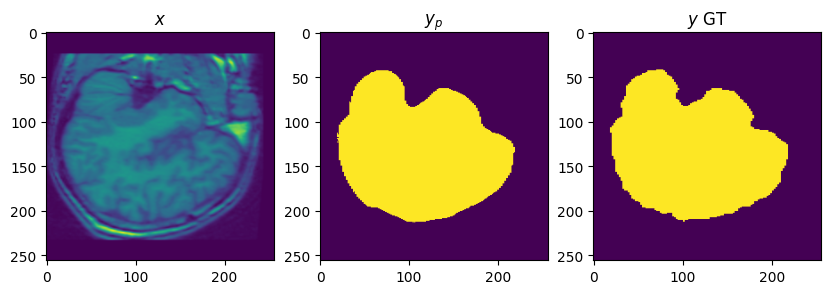

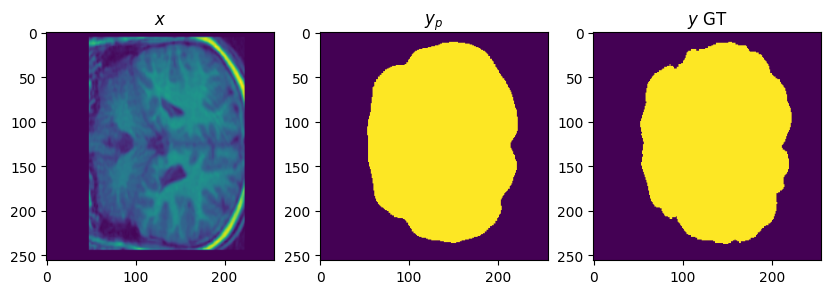

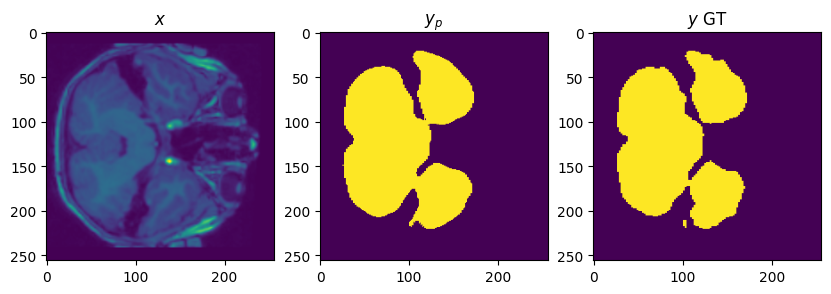

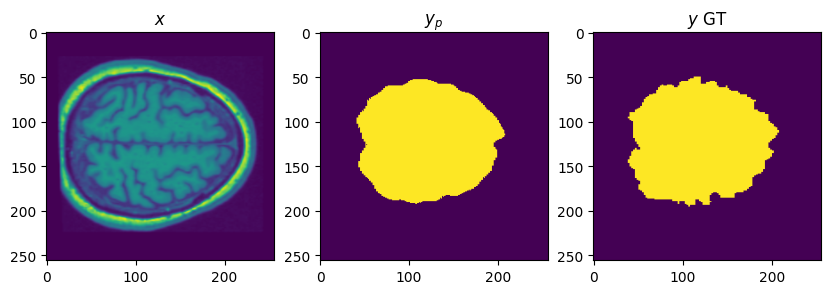

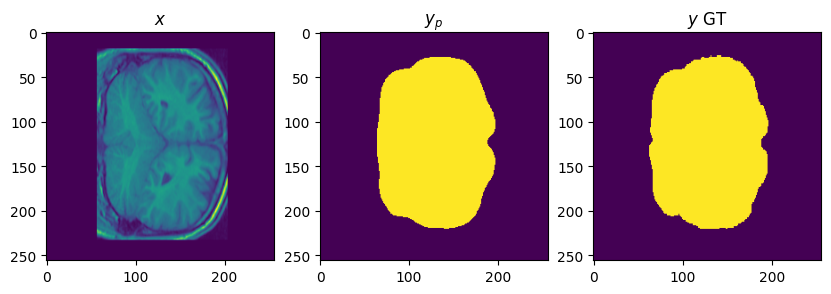

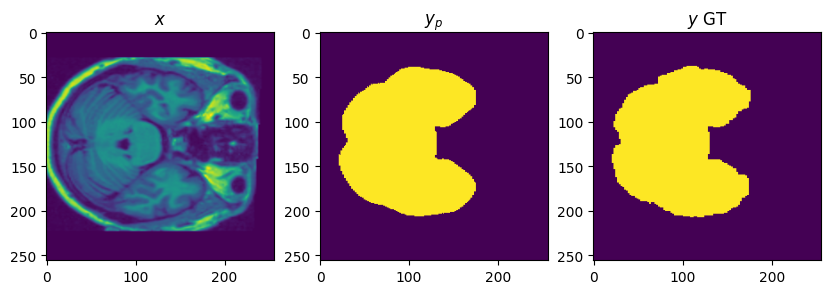

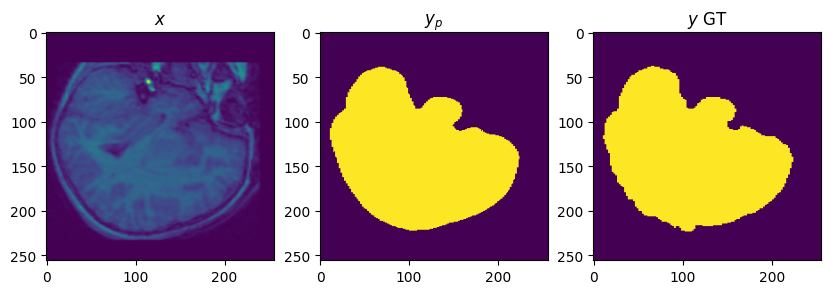

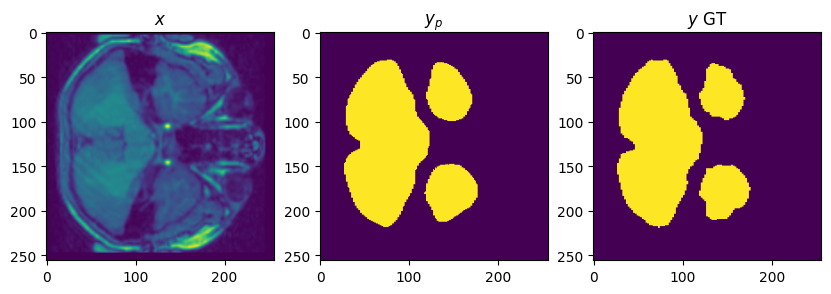

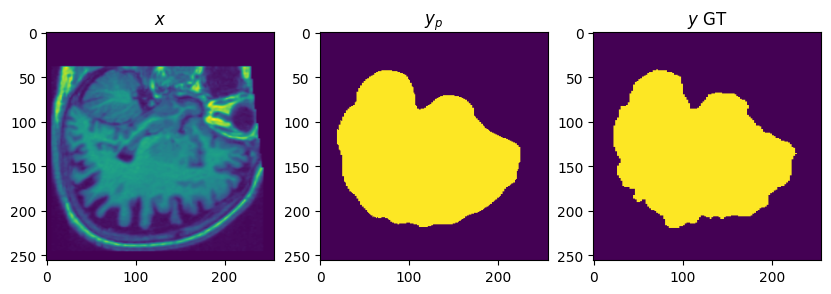

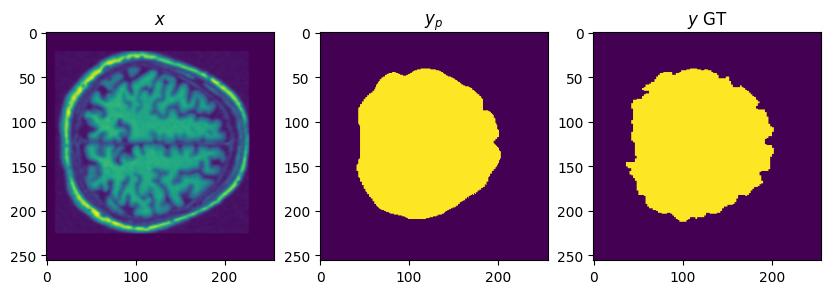

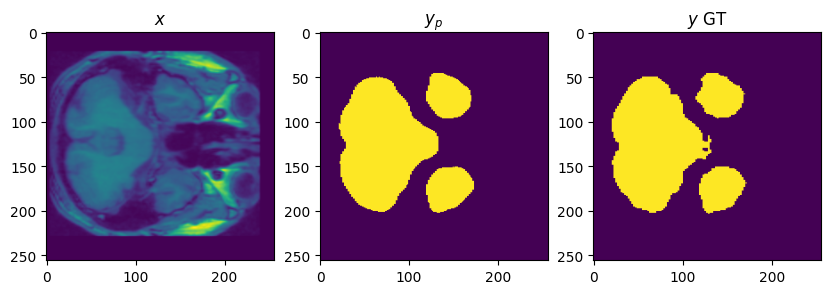

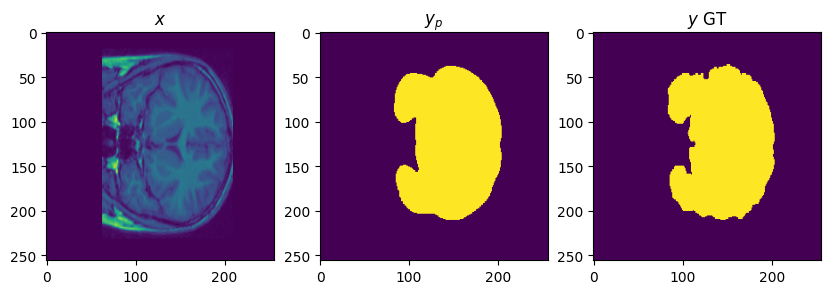

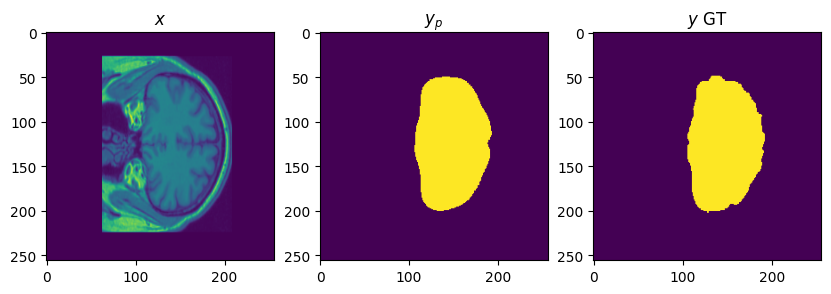

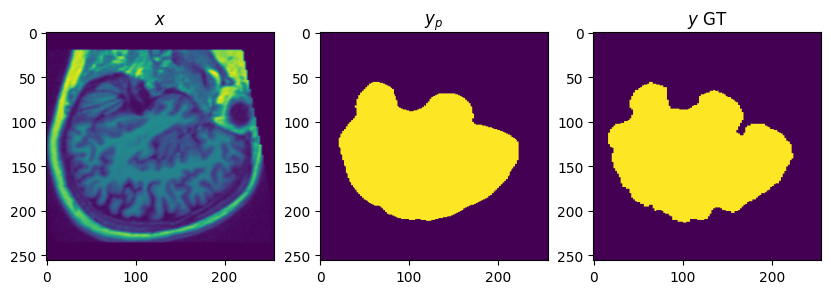

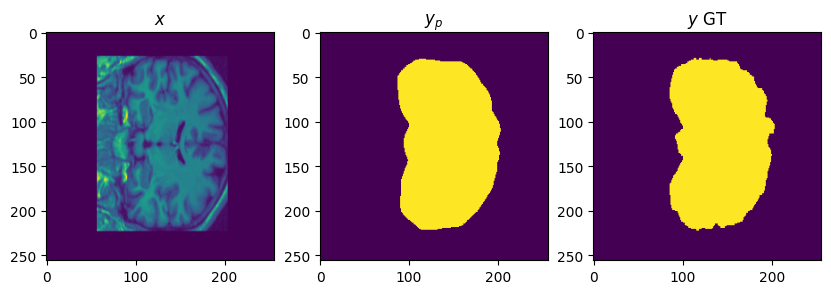

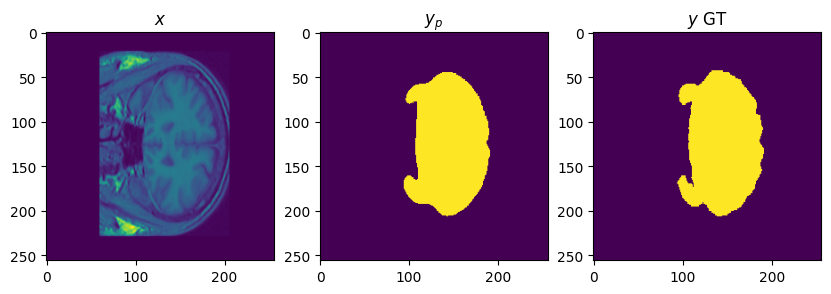

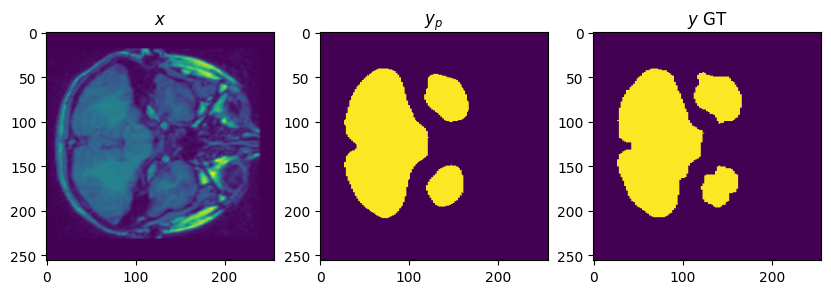

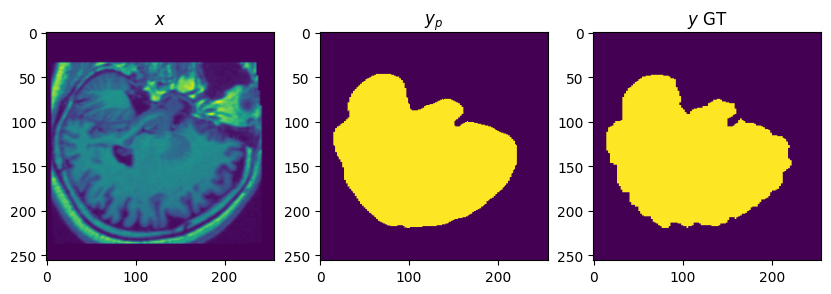

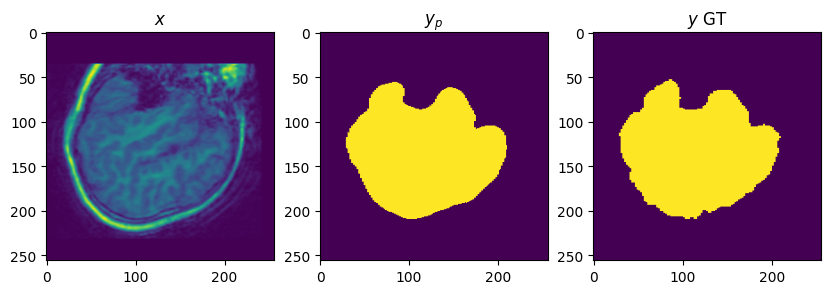

In [57]:
count=0
for batch in test_iterator:
    a, b = batch
    b = np.argmax(b, axis=-1)
    print(a.shape, b.shape)
    yhat = model.predict(a)
    print(yhat.shape,'<<')
    yhat = np.argmax(yhat, axis=-1)
    print(yhat.shape,'<<')


    for k in range(a.shape[0]):
        plt.figure(figsize=(10,3))
        plt.subplot(131), plt.imshow(a[k,:,:,:]), plt.title('$x$')
        plt.subplot(132), plt.imshow(yhat[k,:,:,]), plt.title('$y_p$')
        plt.subplot(133), plt.imshow(b[k,:,:]), plt.title('$y$ GT')
        plt.show()

    count+=1
    if count == 1:
        break